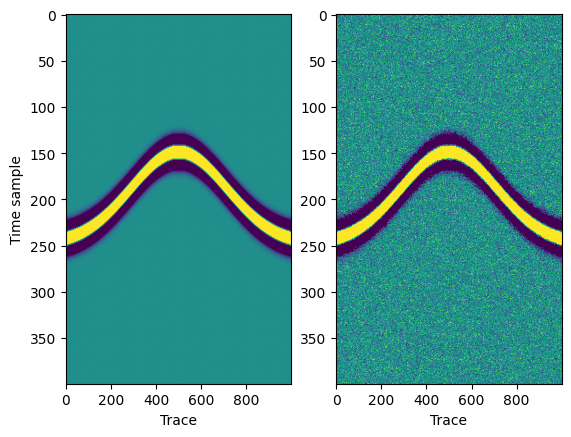

In [1]:
# Prepared On January 6, 2025 by Yangkang Chen, UT-Austin
#
# As a reproduced example for two papers
# [1] Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.
# [2] Saad, O. M., & Chen, Y. (2021). A fully unsupervised and highly generalized deep learning approach for random noise suppression. Geophysical Prospecting, 69(4), 709-726.
# [3] Saad, O.M., Chen, Y.F., Siervo, D., Zhang, F., Savvaidis, A., Huang, G., Igonin, N., Fomel, S., and Chen, Y., (2023). EQCCT: A production-ready EarthQuake detection and phase picking method using the Compact Convolutional Transformer, IEEE Transactions on Geoscience and Remote Sensing, 61, 4507015, doi:10.1109/TGRS.2023.3319440.
# [4] Chen, Y., Savvaidis, A., Saad, O.M., Siervo, D., Huang, G., Chen, Y.F., Grigoratos, I., Fomel, S., and Breton, C., (2024). Thousands of Induced Earthquakes per Month in West Texas Detected Using EQCCT, Geosciences, 14(5), 114, doi: 10.3390/geosciences14050114.
# 
# NOTE: both examples are unsupervised learning approaches. 
# Please use the latest pyseistr package:
# https://github.com/aaspip/pyseistr
#
# Environment: 
# CPU machine
# conda create -n uml python=3.11.7
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.14.0 scikit-learn==1.2.2 seaborn==0.13.2 
# 
# GPU machine
# conda create -n uml python=3.10.14
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.11.0 scikit-learn==1.2.2 seaborn==0.13.2 
# conda install -c anaconda cudnn==8.2.1
#
#
#generate data
import numpy as np
from pyseistr import gensyn
data,noisy=gensyn(noise=True);[n1,n2]=data.shape;
import matplotlib.pyplot as plt;
plt.subplot(1,2,1);plt.imshow(data,clim=[-0.2,0.2],aspect='auto');plt.xlabel('Trace');plt.ylabel('Time sample');
plt.subplot(1,2,2);plt.imshow(noisy,clim=[-0.2,0.2],aspect='auto');plt.xlabel('Trace');
plt.show();


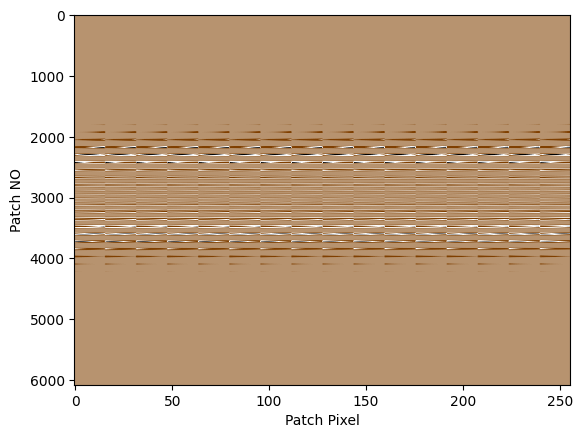

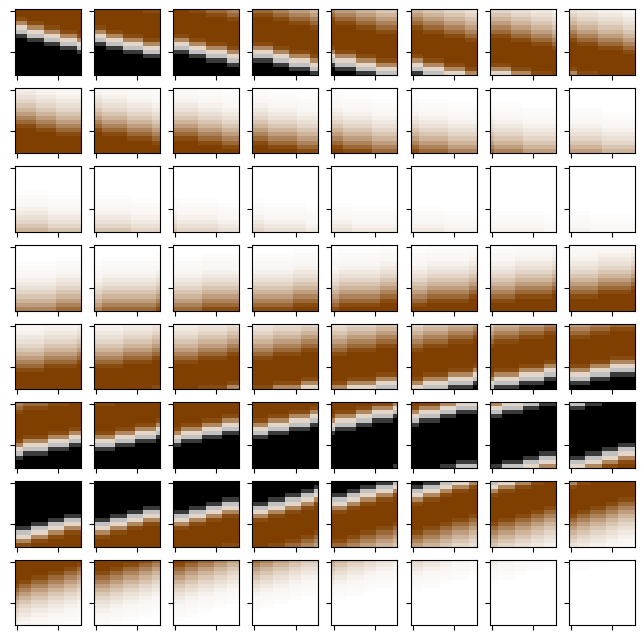

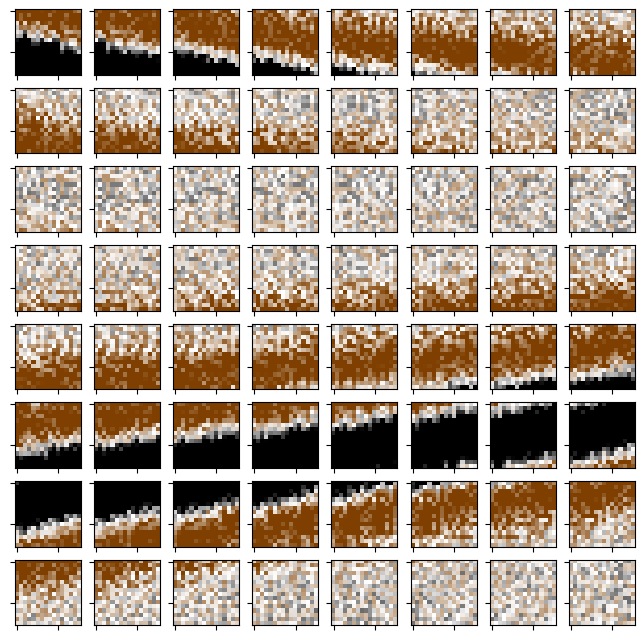

In [2]:
from pyseistr import patch2d,patch2d_inv,snr
X=patch2d(data,l1=16,l2=16,s1=8,s2=8);
Xnoisy=patch2d(noisy,l1=16,l2=16,s1=8,s2=8);

from pyseistr import cseis
plt.imshow(X,aspect='auto',cmap=cseis());plt.ylabel('Patch NO');plt.xlabel('Patch Pixel');plt.show()

# plot clean patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(X[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()


In [3]:
from keras import layers
from keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, LeakyReLU,BatchNormalization
# from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# The following architecture was used in 
# Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.

input = layers.Input(shape=(256,))                            #or from tensorflow.keras.layers import Input, Dense
x = layers.Dense(64, activation="relu", name="layer1")(input)  
x = layers.Dense(256, activation="linear", name="layer2")(x)  

# Autoencoder
autoencoder = Model(input,x)
autoencoder.summary()

# Compile
autoencoder.compile(optimizer="adam", loss='mse')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 layer1 (Dense)              (None, 64)                16448     
                                                                 
 layer2 (Dense)              (None, 256)               16640     
                                                                 
Total params: 33,088
Trainable params: 33,088
Non-trainable params: 0
_________________________________________________________________


2025-01-06 17:02:30.625781: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import datetime
today=datetime.date.today()
weightname='best_model_%s.weights.h5'%str(today)


checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=20,callbacks=[checkpoint,lr_reducer],validation_split=0.2)


Epoch 1/20
 1/38 [..............................] - ETA: 12s - loss: 0.0421
Epoch 1: val_loss improved from inf to 0.01542, saving model to best_model_2025-01-06.weights.h5
38/38 [==============================] - 1s 5ms/step - loss: 0.0348 - val_loss: 0.0154 - lr: 0.0010
Epoch 2/20
35/38 [==========================>...] - ETA: 0s - loss: 0.0183
Epoch 2: val_loss improved from 0.01542 to 0.01448, saving model to best_model_2025-01-06.weights.h5
38/38 [==============================] - 0s 2ms/step - loss: 0.0182 - val_loss: 0.0145 - lr: 0.0010
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.0161
Epoch 3: val_loss improved from 0.01448 to 0.01393, saving model to best_model_2025-01-06.weights.h5
38/38 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0139 - lr: 0.0010
Epoch 4/20
 1/38 [..............................] - ETA: 0s - loss: 0.0156
Epoch 4: val_loss improved from 0.01393 to 0.01360, saving model to best_model_2025-01-06.weights.h5

In [5]:
Xout = autoencoder.predict(Xnoisy)

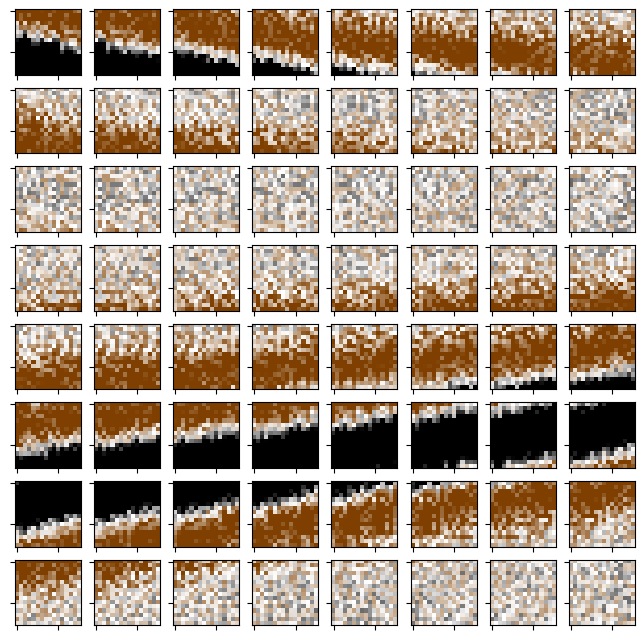

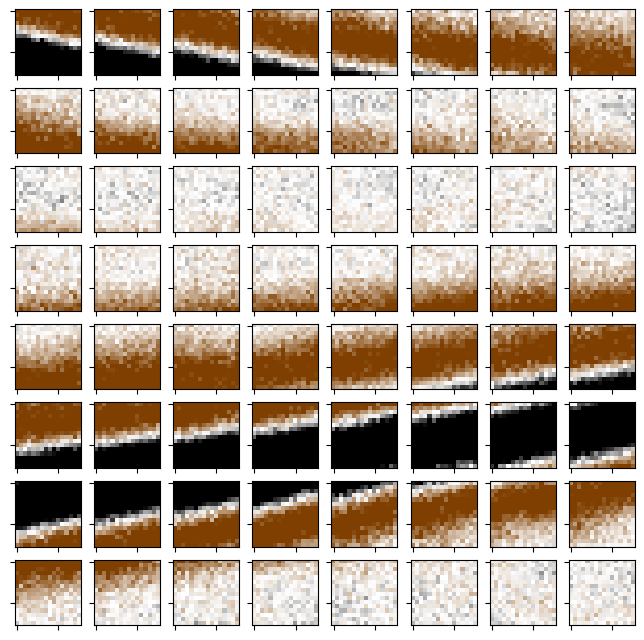

In [6]:
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xout[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()


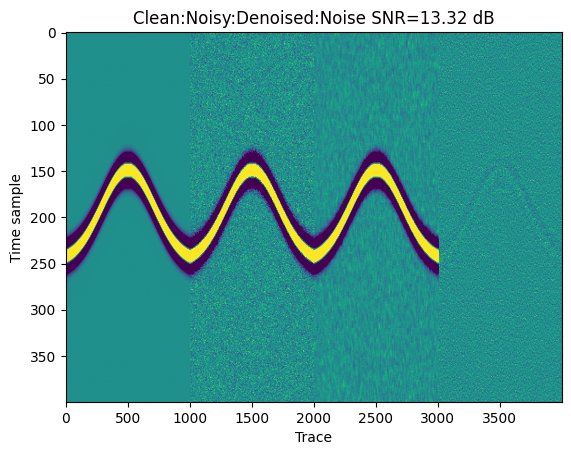

In [7]:
# reconstruct data
denoised=patch2d_inv(Xout,n1,n2,l1=16,l2=16,s1=8,s2=8);

plt.imshow(np.concatenate([data,noisy,denoised,noisy-denoised],axis=1),clim=[-0.2,0.2],aspect='auto');
plt.xlabel('Trace');plt.ylabel('Time sample');plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised)))
plt.show();

In [8]:
import tensorflow as tf
conv_layers = 2 
w1=20
projection_dim = int(2*w1)
num_heads = 4
positional_emb = False
stochastic_depth_rate = 0.1
transformer_layers = 4

transformer_units = [
	projection_dim,
	projection_dim,
]  # Size of the transformer layers

def mlp(x, hidden_units, dropout_rate):
	for units in hidden_units:
		x = layers.Dense(units, activation=tf.nn.gelu)(x)
		#x = layers.Dense(units, activation='relu')(x)
		x = layers.Dropout(dropout_rate)(x)
	return x
    
class CCTTokenizer1d(layers.Layer):
	def __init__(
		self,
		kernel_size=4,
		stride=1,
		padding=1,
		pooling_kernel_size=3,
		pooling_stride=(2,2,2,2,2,2,2,2),
		num_conv_layers=conv_layers,
		num_output_channels=[int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim)],
		positional_emb=positional_emb,
		**kwargs,
	):
		super(CCTTokenizer1d, self).__init__(**kwargs)

		# This is our tokenizer.
		self.conv_model = tf.keras.Sequential()
		for i in range(num_conv_layers):
			self.conv_model.add(
				layers.Conv1D(
					num_output_channels[i],
					kernel_size,
					stride,
					padding="same",
					use_bias=False,
					activation="relu",
					kernel_initializer="he_normal",
				)
			)
			#self.conv_model.add(layers.ZeroPadding2D(padding))
			self.conv_model.add(
				layers.MaxPool1D(pooling_kernel_size, (pooling_stride[i]), "same")
			)

		self.positional_emb = positional_emb

	def call(self, images):
		outputs = self.conv_model(images)
		# After passing the images through our mini-network the spatial dimensions
		# are flattened to form sequences.
		reshaped = tf.reshape(
			outputs,
			(-1, tf.shape(outputs)[1], tf.shape(outputs)[-1]),
		)
		return reshaped

	def positional_embedding(self, image_size):
		# Positional embeddings are optional in CCT. Here, we calculate
		# the number of sequences and initialize an `Embedding` layer to
		# compute the positional embeddings later.
		if self.positional_emb:
			dummy_inputs = tf.ones((1, image_size, 1))
			dummy_outputs = self.call(dummy_inputs)
			sequence_length = dummy_outputs.shape[1]
			projection_dim = dummy_outputs.shape[-1]

			print(dummy_outputs,sequence_length,projection_dim)
			embed_layer = layers.Embedding(
				input_dim=sequence_length, output_dim=projection_dim
			)
			return embed_layer, sequence_length
		else:
			return None
			
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
	def __init__(self, drop_prop, **kwargs):
		super(StochasticDepth, self).__init__(**kwargs)
		self.drop_prob = drop_prop

	def call(self, x, training=None):
		if training:
			keep_prob = 1 - self.drop_prob
			shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
			random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
			random_tensor = tf.floor(random_tensor)
			return (x / keep_prob) * random_tensor
		return x


In [9]:
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten, Reshape

def create_cct_model(inputs):


	# Augment data.
	#augmented = data_augmentation(inputs)

	# Encode patches.
	cct_tokenizer = CCTTokenizer1d()
	encoded_patches = cct_tokenizer(inputs)

	# Apply positional embedding.
	if positional_emb:
		pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
		positions = tf.range(start=0, limit=seq_length, delta=1)
		position_embeddings = pos_embed(positions)
		encoded_patches += position_embeddings

	# Calculate Stochastic Depth probabilities.
	dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

	# Create multiple layers of the Transformer block.
	for i in range(transformer_layers):
		# Layer normalization 1.
		x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

		# Create a multi-head attention layer.
		attention_output = layers.MultiHeadAttention(
			num_heads=num_heads, key_dim=projection_dim, dropout=0.2
		)(x1, x1)

		#print(encoded_patches)
		# Skip connection 1.
		attention_output = StochasticDepth(dpr[i])(attention_output)
		x2 = layers.Add()([attention_output, encoded_patches])

		# Layer normalization 2.
		x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
		#x3 = x2
		
		# MLP.
		x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)

		# Skip connection 2.
		#print(x3)
		x3 = StochasticDepth(dpr[i])(x3)
		#print(x3)
		encoded_patches = layers.Add()([x3, x2])
	 
	# Apply sequence pooling.
	representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
	
	''' 
	attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
	weighted_representation = tf.matmul(
		attention_weights, representation, transpose_a=True
	)
	weighted_representation = tf.squeeze(weighted_representation, -2)
	'''
	return representation


def construct_model(input_shape):
	'''
	
	construct_model: construct the EQpolarity model
	
	'''
	inputs = layers.Input(shape=input_shape,name='input')

	featuresP = create_cct_model(inputs)
	featuresP = layers.Flatten()(featuresP)
	featuresP = layers.Dropout(0.2)(featuresP)
	logitp = layers.Dense(input_shape[0]*input_shape[1], activation='linear')(featuresP) #input_shape->256
	logitp = Reshape(input_shape)(logitp)

	model = Model(inputs=[inputs], outputs=[logitp])
# 	model.summary()
	return model

In [10]:
model=construct_model((256,1))
model.compile(optimizer="adam", loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 1)]     0           []                               
                                                                                                  
 cct_tokenizer1d (CCTTokenizer1  (None, 64, 40)      6560        ['input[0][0]']                  
 d)                                                                                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 64, 40)      80          ['cct_tokenizer1d[0][0]']        
 alization)                                                                                       
                                                                                            

 dropout_4 (Dropout)            (None, 64, 40)       0           ['dense_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 64, 40)       1640        ['dropout_4[0][0]']              
                                                                                                  
 dropout_5 (Dropout)            (None, 64, 40)       0           ['dense_5[0][0]']                
                                                                                                  
 stochastic_depth_5 (Stochastic  (None, 64, 40)      0           ['dropout_5[0][0]']              
 Depth)                                                                                           
                                                                                                  
 add_5 (Add)                    (None, 64, 40)       0           ['stochastic_depth_5[0][0]',     
          

In [11]:
checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

model.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=20,callbacks=[checkpoint,lr_reducer],validation_split=0.2)


Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.7013
Epoch 1: val_loss improved from inf to 0.02836, saving model to best_model_2025-01-06.weights.h5
38/38 [==============================] - 25s 585ms/step - loss: 0.7013 - val_loss: 0.0284 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.3356
Epoch 2: val_loss improved from 0.02836 to 0.01932, saving model to best_model_2025-01-06.weights.h5
38/38 [==============================] - 23s 610ms/step - loss: 0.3356 - val_loss: 0.0193 - lr: 0.0010
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.1978
Epoch 3: val_loss improved from 0.01932 to 0.01728, saving model to best_model_2025-01-06.weights.h5
38/38 [==============================] - 22s 593ms/step - loss: 0.1978 - val_loss: 0.0173 - lr: 0.0010
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.0954
Epoch 4: val_loss improved from 0.01728 to 0.01535, saving model to best_model_2025-01-06.we

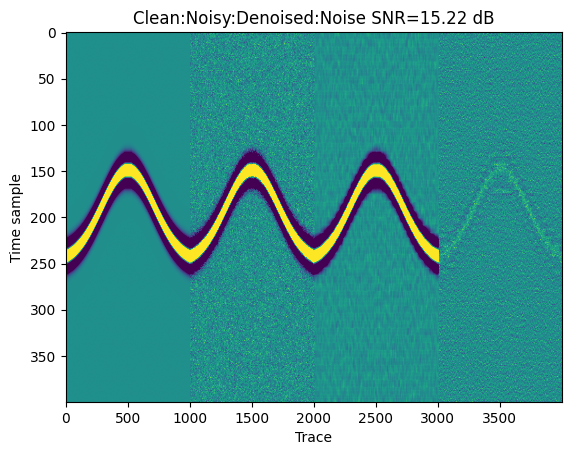

In [12]:
Xout = model.predict(Xnoisy)

# reconstruct data
denoised=patch2d_inv(Xout,n1,n2,l1=16,l2=16,s1=8,s2=8);

plt.imshow(np.concatenate([data,noisy,denoised,noisy-denoised],axis=1),clim=[-0.2,0.2],aspect='auto');
plt.xlabel('Trace');plt.ylabel('Time sample');plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised)))
plt.show();